In [1]:
# !pip install black
# !pip install yfinance
# !pip install scikit-learn
# !pip install --upgrade scipy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader  # 可以将导入合并为一行
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import yfinance as yf
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib.font_manager import FontProperties
from datetime import datetime, timedelta

matplotlib.rcParams["font.family"] = "Noto Sans CJK JP"

## 超参数设定

In [3]:
config = {
    "yahoo_finance": {
        "symbol": "KO",  # 可口可乐的股票代码
        "start_date": "1999-02-03",  # 开始日期，根据需要调整
        "interval": "1d",  # 数据间隔，可以是1d（每日），1wk（每周），1mo（每月）
    },
    "data": {
        "window_size": 20,  # 数据窗口大小，用于特征工程
        "train_split_size": 0.85,  # 训练集和测试集的划分比例
    },
    "plots": {
        "show_plots": True,  # 是否显示图表
        "xticks_interval": 90,  # 图表的X轴刻度间隔
        "color_actual": "#001f3f",  # 实际值的颜色
        "color_train": "#3D9970",  # 训练集的颜色
        "color_val": "#0074D9",  # 验证集的颜色
        "color_pred_train": "#3D9970",  # 训练集预测值的颜色
        "color_pred_val": "#0074D9",  # 验证集预测值的颜色
        "color_pred_test": "#FF4136",  # 测试集预测值的颜色
    },
    "model": {
        "input_size": 1,  # 使用单一特征，即收盘价
        "num_lstm_layers": 2,  # LSTM层的数量
        "lstm_size": 32,  # LSTM单元的大小
        "dropout": 0.2,  # Dropout比率
    },
    "training": {
        "device": "cuda",  # 使用GPU进行训练
        "batch_size": 64,  # 批处理大小
        "num_epoch": 100,  # 训练周期数
        "learning_rate": 0.01,  # 学习率
        "scheduler_step_size": 40,  # 学习率调度器的步长
    },
}

In [4]:
def get_data_from_yahoo(symbol, start_date, end_date=None):
    cache_filename = f"{symbol}_{start_date}_to_{end_date}.pkl"

    # 检查缓存文件是否存在且未过时
    if os.path.exists(cache_filename):
        file_mod_time = datetime.fromtimestamp(os.path.getmtime(cache_filename))
        if datetime.now() - file_mod_time < timedelta(days=1):  # 例如，这里设置为1天，请根据时差和假期自行调整
            print("Loaded data from cache")
            return pd.read_pickle(cache_filename)

    # 缓存不存在或过时，下载数据
    print("Downloading data...")
    ticker = yf.Ticker(symbol)
    data = ticker.history(start=start_date, end=end_date)

    if data.empty:
        print("No data downloaded, check your symbol, dates or network connection.")
    else:
        data.to_pickle(cache_filename)
        print("Downloaded data and saved to cache")

    return data

In [5]:
# if torch.cuda.is_available():
#     print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
# else:
#     print("CUDA is not available. Please check your installation.")

## 从 雅虎财经准备股票价格数据

Number of data points: 6291 from 1999-02-03 to 2024-02-02


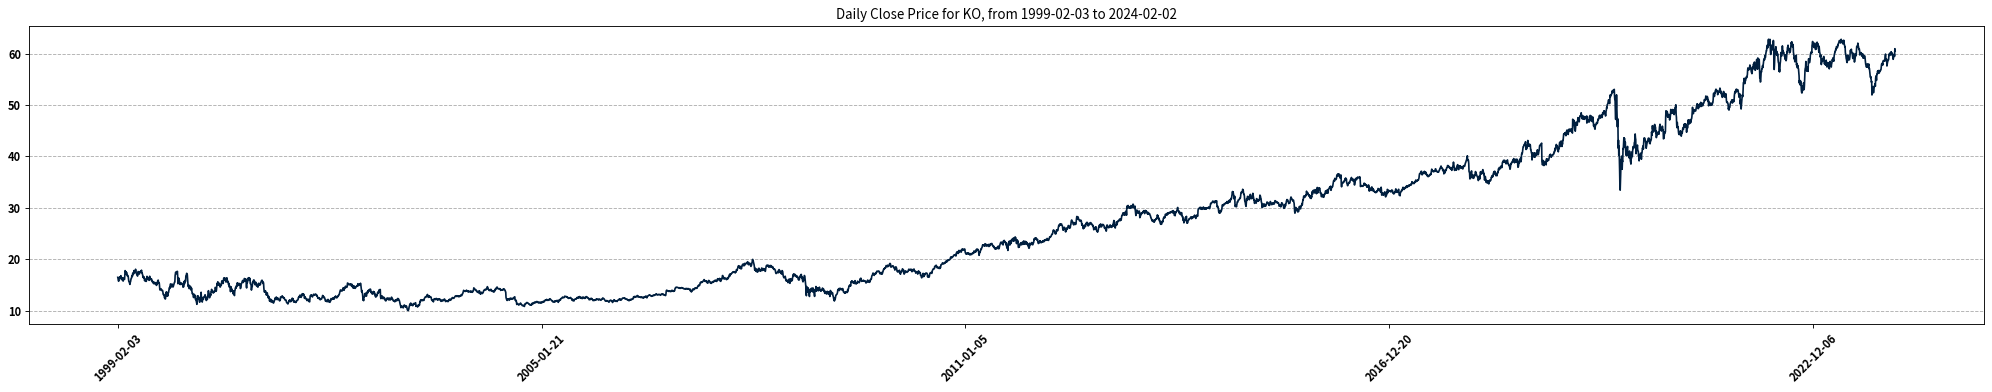

In [6]:
def download_data(config, plot=False):
    symbol = config["yahoo_finance"]["symbol"]
    start_date = config["yahoo_finance"]["start_date"]
    # 使用yfinance下载数据
    ticker = yf.Ticker(symbol)
    data = ticker.history(start=start_date)

    # 提取日期和调整后的收盘价
    data_date = data.index.strftime("%Y-%m-%d").tolist()
    data_close_price = data["Close"].values

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[-1]
    print("Number of data points:", num_data_points, display_date_range)

    if plot:
        # 增加图表的宽度
        fig = figure(figsize=(25, 5), dpi=80)  # 增大图表宽度
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])

        # 旋转标签以节省空间
        plt.xticks(rotation=45)  # 旋转45度可以改善标签的可读性

        # 使用MaxNLocator来限制X轴上的主刻度数量
        plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))  # 根据图表的宽度调整nbins的值

        # 设置图表标题
        plt.title("Daily Close Price for " + symbol + ", " + display_date_range)

        # 显示网格线
        plt.grid(visible=True, which="major", axis="y", linestyle="--")

        # 使用tight_layout确保元素不重叠
        plt.tight_layout()

        # 显示图表
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range


# 示例用法（确保config中已经更新了yahoo_finance部分）
config["plots"]["xticks_interval"] = 90
data_date, data_close_price, num_data_points, display_date_range = download_data(
    config, plot=config["plots"]["show_plots"]
)

##  归一化数据（Normalization）---，正态分布，Z分数归一

In [7]:
class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.sd = np.std(x, axis=0, keepdims=True)
        # 避免除以零
        self.sd[self.sd == 0] = 1
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu


# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

## 生成训练集和验证集

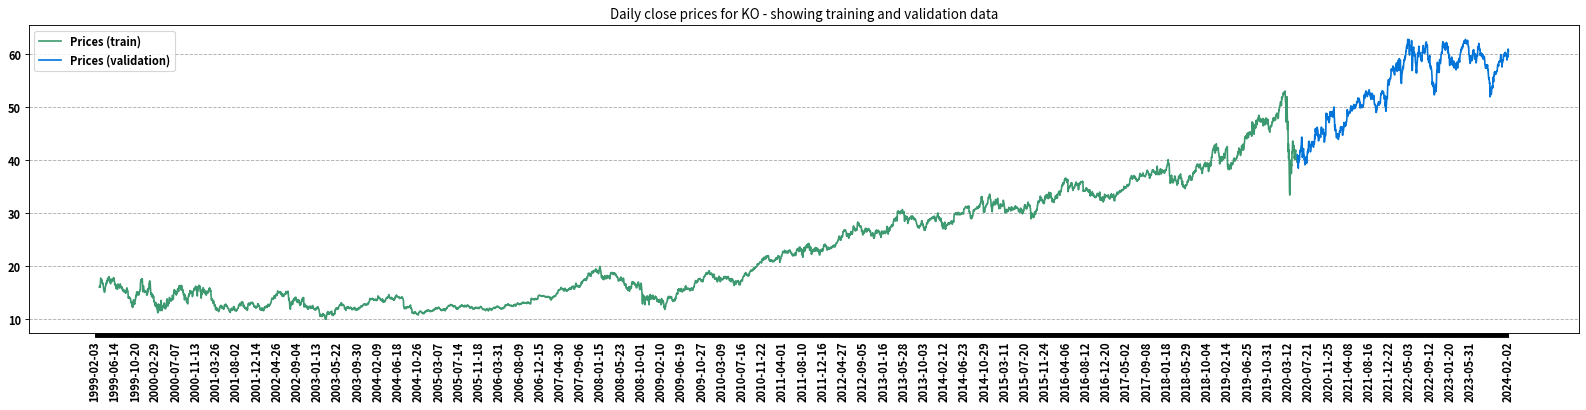

In [8]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(
        x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0])
    )
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output


def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(
        normalized_data_close_price, window_size=config["data"]["window_size"]
    )
    data_y = prepare_data_y(
        normalized_data_close_price, window_size=config["data"]["window_size"]
    )

    # split dataset

    split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[
            config["data"]["window_size"] : split_index + config["data"]["window_size"]
        ] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[
            split_index + config["data"]["window_size"] :
        ] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(
            to_plot_data_y_train == 0, None, to_plot_data_y_train
        )
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(
            data_date,
            to_plot_data_y_train,
            label="Prices (train)",
            color=config["plots"]["color_train"],
        )
        plt.plot(
            data_date,
            to_plot_data_y_val,
            label="Prices (validation)",
            color=config["plots"]["color_val"],
        )
        xticks = [
            data_date[i]
            if (
                (
                    i % config["plots"]["xticks_interval"] == 0
                    and (num_data_points - i) > config["plots"]["xticks_interval"]
                )
                or i == num_data_points - 1
            )
            else None
            for i in range(num_data_points)
        ]  # make x ticks nice
        x = np.arange(0, len(xticks))
        plt.xticks(x, xticks, rotation="vertical")
        plt.title(
            "Daily close prices for "
            + config["yahoo_finance"]["symbol"]
            + " - showing training and validation data"
        )
        plt.grid(visible=True, which="major", axis="y", linestyle="--")
        plt.legend()
        plt.show()

    return (
        split_index,
        data_x_train,
        data_y_train,
        data_x_val,
        data_y_val,
        data_x_unseen,
    )


(
    split_index,
    data_x_train,
    data_y_train,
    data_x_val,
    data_y_val,
    data_x_unseen,
) = prepare_data(
    normalized_data_close_price, config, plot=config["plots"]["show_plots"]
)

In [9]:
# 创建时间序列，并让他符合LSTM的格式
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("训练数据形态", dataset_train.x.shape, dataset_train.y.shape)
print("验证数据形态", dataset_val.x.shape, dataset_val.y.shape)

训练数据形态 (5330, 20, 1) (5330,)
验证数据形态 (941, 20, 1) (941,)


## 建模

In [10]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size=1,
        hidden_layer_size=32,
        num_layers=2,
        output_size=1,
        dropout=0.2,
    ):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(
            hidden_layer_size,
            hidden_size=self.hidden_layer_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers * hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight_ih" in name:
                nn.init.kaiming_normal_(param)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:, -1]


model = LSTMModel(
    input_size=config["model"]["input_size"],
    hidden_layer_size=config["model"]["lstm_size"],
    num_layers=config["model"]["num_lstm_layers"],
    output_size=1,
    dropout=config["model"]["dropout"],
)
model = model.to(config["training"]["device"])

## 训练模型

Epoch[1/100] | loss train:0.003126, test:0.003270 | lr:0.000100
Epoch[2/100] | loss train:0.003218, test:0.003768 | lr:0.000100
Epoch[3/100] | loss train:0.003058, test:0.003889 | lr:0.000100
Epoch[4/100] | loss train:0.003472, test:0.003564 | lr:0.000100
Epoch[5/100] | loss train:0.003132, test:0.004156 | lr:0.000100
Epoch[6/100] | loss train:0.003162, test:0.004029 | lr:0.000100
Epoch[7/100] | loss train:0.003073, test:0.003548 | lr:0.000100
Epoch[8/100] | loss train:0.002939, test:0.003707 | lr:0.000100
Epoch[9/100] | loss train:0.003019, test:0.002845 | lr:0.000100
Epoch[10/100] | loss train:0.003128, test:0.003712 | lr:0.000100
Epoch[11/100] | loss train:0.003063, test:0.003787 | lr:0.000100
Epoch[12/100] | loss train:0.003128, test:0.003757 | lr:0.000100
Epoch[13/100] | loss train:0.003118, test:0.003418 | lr:0.000100
Epoch[14/100] | loss train:0.003027, test:0.003301 | lr:0.000100
Epoch[15/100] | loss train:0.003178, test:0.004009 | lr:0.000100
Epoch[16/100] | loss train:0.00307

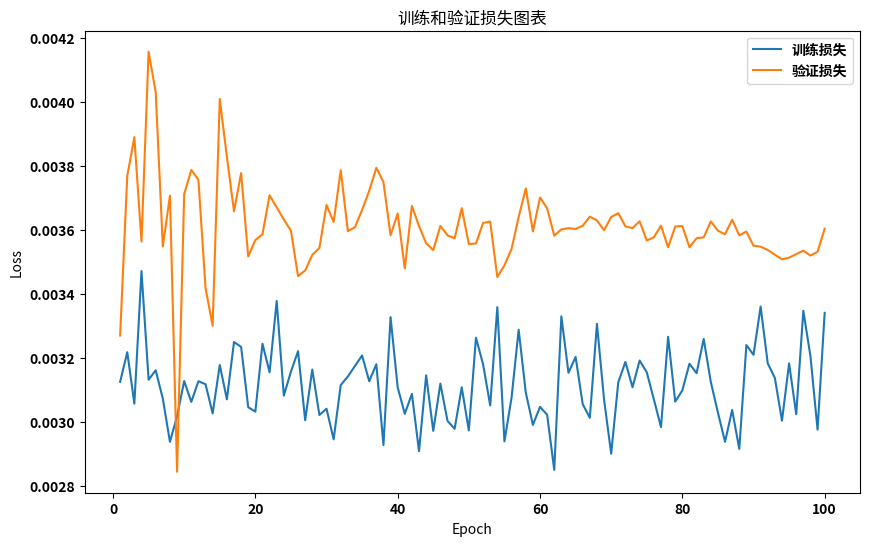

In [11]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.detach().item() / batchsize

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr


# create `DataLoader`
train_dataloader = DataLoader(
    dataset_train, batch_size=config["training"]["batch_size"], shuffle=True
)
val_dataloader = DataLoader(
    dataset_val, batch_size=config["training"]["batch_size"], shuffle=True
)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=config["training"]["learning_rate"],
    betas=(0.9, 0.98),
    eps=1e-9,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1
)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()


# 定义两个空列表，用于存储训练损失和验证损失
train_losses = []
val_losses = []

# 开始训练
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    # 将当前Epoch的训练和验证损失添加到列表中
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # 打印训练信息
    print(
        "Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}".format(
            epoch + 1, config["training"]["num_epoch"], loss_train, loss_val, lr_train
        )
    )

# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = range(1, config["training"]["num_epoch"] + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="训练损失")  # 修改为中文
plt.plot(epochs, val_losses, label="验证损失")
plt.title("训练和验证损失图表")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 评估模型

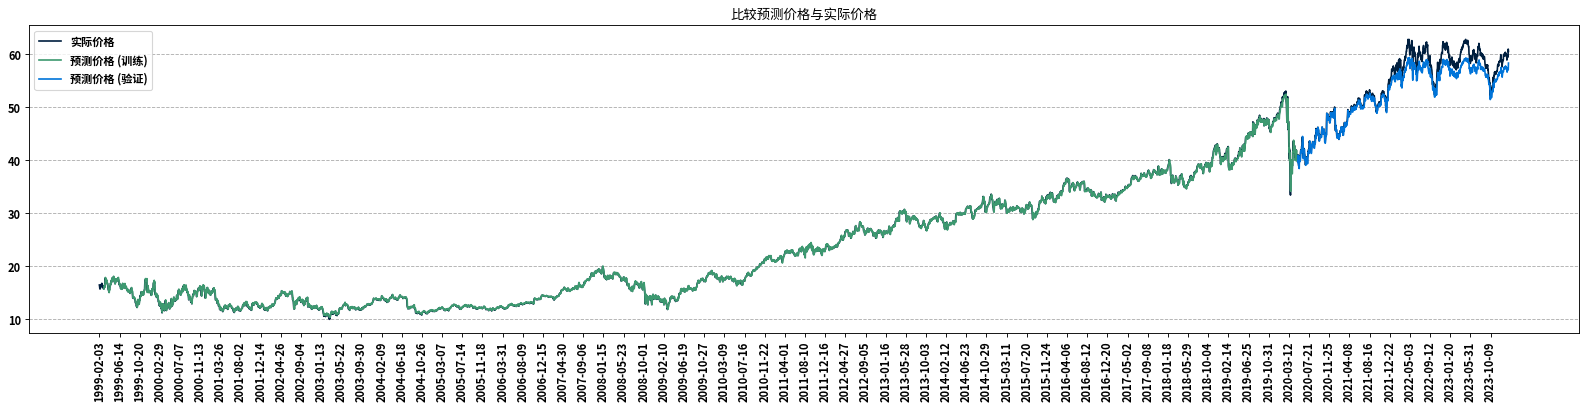

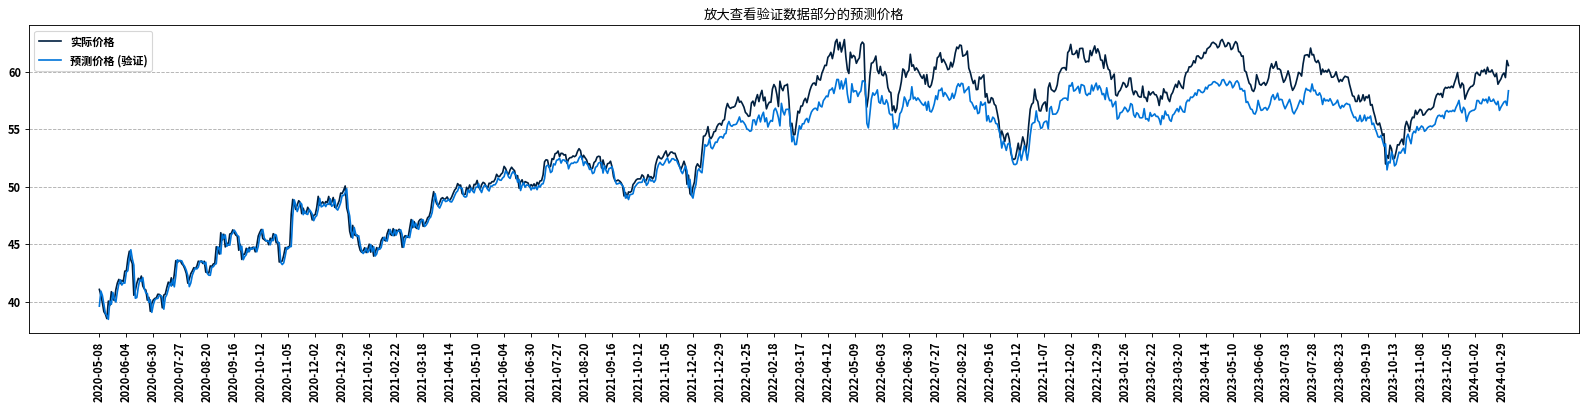

In [12]:
train_dataloader = DataLoader(
    dataset_train, batch_size=config["training"]["batch_size"], shuffle=False
)
val_dataloader = DataLoader(
    dataset_val, batch_size=config["training"]["batch_size"], shuffle=False
)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:
    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[
        config["data"]["window_size"] : split_index + config["data"]["window_size"]
    ] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[
        split_index + config["data"]["window_size"] :
    ] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(
        to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred
    )
    to_plot_data_y_val_pred = np.where(
        to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred
    )

    # plots

    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(
        data_date,
        data_close_price,
        label="实际价格",
        color=config["plots"]["color_actual"],
    )
    plt.plot(
        data_date,
        to_plot_data_y_train_pred,
        label="预测价格 (训练)",
        color=config["plots"]["color_pred_train"],
    )
    plt.plot(
        data_date,
        to_plot_data_y_val_pred,
        label="预测价格 (验证)",
        color=config["plots"]["color_pred_val"],
    )
    plt.title("比较预测价格与实际价格")
    x = np.arange(0, len(data_date), config["plots"]["xticks_interval"])
    plt.xticks(x, [data_date[i] for i in x], rotation="vertical")
    plt.grid(True, which="major", axis="y", linestyle="--")  # 修复后的代码
    plt.legend()
    plt.show()

    # 放大验证部分的准备

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index + config["data"]["window_size"] :]

    # 绘制放大的验证数据部分的图表
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(
        to_plot_data_date,
        to_plot_data_y_val_subset,
        label="实际价格",
        color=config["plots"]["color_actual"],
    )
    plt.plot(
        to_plot_data_date,
        to_plot_predicted_val,
        label="预测价格 (验证)",
        color=config["plots"]["color_pred_val"],
    )
    plt.title("放大查看验证数据部分的预测价格")
    xs = np.arange(
        0, len(to_plot_data_date), int(config["plots"]["xticks_interval"] / 5)
    )
    plt.xticks(xs, [to_plot_data_date[i] for i in xs], rotation="vertical")
    plt.grid(True, which="major", axis="y", linestyle="--")  # 修复后的代码
    plt.legend()
    plt.show()

## 预测未来三天股票价格

In [13]:
# 设定未来天数
num_future_days = 3
future_dates = ["next trading day 1", "next trading day 2", "next trading day 3"]

# 初始数据用于预测的最后一个时间点
x_unseen = data_x_unseen

# 存储未来预测
future_predictions = []

# 迭代预测未来3天的价格
for _ in range(num_future_days):
    model.eval()  # 确保模型在评估模式下
    x_tensor = (
        torch.tensor(x_unseen)
        .float()
        .unsqueeze(0)
        .unsqueeze(2)
        .to(config["training"]["device"])
    )
    with torch.no_grad():  # 关闭梯度计算
        prediction = model(x_tensor)
    prediction = prediction.cpu().detach().numpy()
    prediction = scaler.inverse_transform(prediction.reshape(1, -1))[0][0]  # 逆归一化预测值
    future_predictions.append(prediction)

    # 更新x_unseen，使其包含最新的预测值
    x_unseen = np.roll(x_unseen, -1)
    # 归一化最新的预测值并更新x_unseen
    # 注意：这里我们需要将预测值重新归一化以供下一次预测使用
    normalized_prediction = scaler.fit_transform(np.array([[prediction]]))[0]
    x_unseen[-1] = normalized_prediction

# 输出预测结果
future_dates = ["明天", "后天", "大后天"]

# 输出预测结果
for i, (date, pred) in enumerate(zip(future_dates, future_predictions)):
    print(f"股价预测（美元） for {date}: {round(pred, 2)}")

股价预测（美元） for 明天: 57.81
股价预测（美元） for 后天: 58.23
股价预测（美元） for 大后天: 58.61


##  预测明天价格

In [14]:
model.eval()

x = (
    torch.tensor(data_x_unseen)
    .float()
    .to(config["training"]["device"])
    .unsqueeze(0)
    .unsqueeze(2)
)  # 这是模型所需的数据类型和形状
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction.reshape(1, -1))[
    0
]  # 确保prediction具有正确的形状以匹配inverse_transform的期望输入

# 假定prediction已经是一个形状为(1,)的一维数组，我们取出这个单一的值
prediction_scalar = prediction.item()  # 使用.item()从只含一个元素的数组提取标量值

print("明天的股价（美元）:", round(prediction_scalar, 2))

明天的股价（美元）: 60.65
